<a href="https://colab.research.google.com/github/mosesyhc/BAND-camp-surmise-demo/blob/main/BANDcamp2023_GP_surmise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gaussian processes in emulation and calibration using `surmise`**

This notebook covers the basics of Gaussian processes and their usage in emulation and calibration.  Three examples are presented to perform emulation and calibration tasks using the Python package `surmise`.
$\newcommand{\T}{\mathsf{T}}$

## **Emulation**
Consider some expensive simulation code $f(x, \theta)$ that takes $x$ and $\theta$ and returns its output.

The terminologies we general use are:
- **Parameter** $(\theta)$ contains any quantities of interest for calibration.
- **Input** $(x)$ contains other controllable inputs.

### **Key Idea**
If $f$ is considerably expensive to run, we would like to build a *faster* emulator that can
1. **predict at unsimulated parameters**, given the outputs from the simulated parameters, and 
2. **provide uncertainty** around these predictions.

A Gaussian process (GP) is one choice that can achieve both goals naturally.  We assume that $f$ follows a Gaussian process and use a set of simulated outputs to build an emulator for $f$.

### **Setting and data**
The data we need are the simulation outputs from the model, for example, 
$$ \mathbf{f} = (f(x, \theta_1), f(x, \theta_2), ..., f(x, \theta_n))^\mathsf{T}. $$

### **Emulation with Gaussian process**
A (univariate) GP assumes any finite collection of $n$ variables follows a multivariate normal distribution specified by a mean function $\mu(\cdot)$ and a covariance function $c(\cdot, \cdot)$,
$$   \mathbf{f} \sim \mathsf{N}(\boldsymbol \mu, C), $$
where 
\begin{align*}
  \boldsymbol \mu = \begin{pmatrix}
    \mu(\theta_1) \\ \vdots \\ \mu(\theta_n)
  \end{pmatrix},  &\quad 
  C = \begin{pmatrix}
    c(\theta_1, \theta_1) & \ldots & c(\theta_1, \theta_n) \\
    \vdots & \ddots & \vdots \\
    c(\theta_n, \theta_1) & \ldots & c(\theta_n, \theta_n)
  \end{pmatrix}.
\end{align*}

This is basically all we need to build the emulator for $f(\theta)$, at any unsimulated parameter $\theta$.

Conditioning on the simulated outputs, our emulator is, 
$$ f(\theta) ~|~ \mathbf{f} \sim \mathsf{N}(\hat{\mu}(\theta), \hat{\sigma}^2(\theta)),$$

Aligning with the goals of an emulator: 
1. **Prediction** 
$$ \hat{\mu}(\theta) = \mu(\theta) + \boldsymbol c(\theta)^\T C^{-1} \boldsymbol \mu, $$ 
2. **Uncertainty quantification**
$$ \hat{\sigma}^2(\theta) = c(\theta, \theta) - \boldsymbol c(\theta)^\T C^{-1} \boldsymbol c(\theta),$$
where $\boldsymbol c(\theta) = (c(\theta, \theta_1), \ldots c(\theta, \theta_n))^\T$.

---



In [180]:
#@title Basic Python libraries import
# Import numpy and plotting libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [181]:
#@title Ball drop model 
def ball_drop(t, h, k, g):
    """
    Calculates the location of a ball dropped from a height h with initial velocity 0,
    accounting for air resistance with drag coefficient k and mass 1, at time t.

    Args:
    t (float or array of floats): time since the ball was dropped
    h (float): initial height of the ball above the ground
    k (float): drag coefficient
    g (float): gravitational constant

    Returns:
    float or array of floats: the location of the ball at time t
    """
    
    def logcosh(z):
        # preventing crashing
        s = np.sign(z) * z
        p = np.exp(-2 * s)
        return s + np.log1p(p) - np.log(2)
    
    # Calculate terminal velocity using V = sqrt(g / k)
    vt = np.sqrt(g / k)

    # Calculate the location as a function of time
    f = h - (vt ** 2) / g * logcosh(g * t / vt)

    # Return the location at time t
    return f

In [182]:
#@title Ball drop model parameterized with `x, theta`
def ball_drop_xt(x, theta):
    """
    Wraps ball_drop(t, h, k, g) treating x as inputs and theta as parameters, 
    i.e.,   
      x = (t, h), theta = (k, g).

    Returns:
      array of floats: a |x| by |theta| matrix containing prediction for each (x, theta) pair.
    """
    assert x.ndim == 2
    assert theta.ndim == 2

    fpred = np.full(shape=(x.shape[0], theta.shape[0]), fill_value=np.nan)

    for i in range(x.shape[0]):
      for j in range(theta.shape[0]):
        fpred[i, j] = ball_drop(t=x[i, 0], h=x[i, 1], k=theta[j, 0], g=theta[j, 1])

    return fpred

### Visualizing the model a little

Suppose we know the reasonable ranges for the drag coefficient (`k`) and gravitational constant (`g`):
$$ k \in [0.001, 0.5], \quad g \in [5, 40]. $$

*Note: this provides the basis for selection of the **prior** distribution later.*

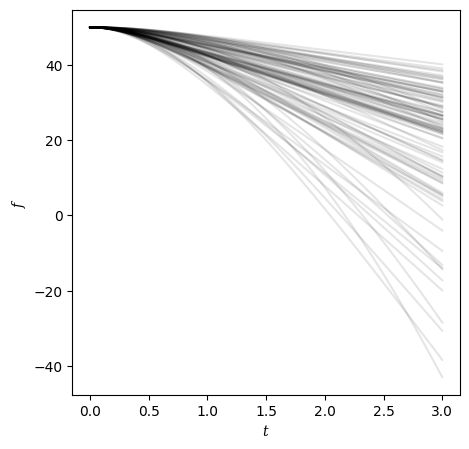

In [183]:
# time points to evaluate this function
t = np.linspace(0, 3, 100)
# initial height
h = 50

kL, kU = (0.001, 0.5)
gL, gU = (5, 40)

# randomly guess 100 parameters
n = 100
kvec = np.random.uniform(kL, kU, n)
gvec = np.random.uniform(gL, gU, n)

plt.figure(figsize=(5, 5))
for i in range(n):
  f_pred = ball_drop(t, h, kvec[i], gvec[i])
  plt.plot(t, f_pred, 'k', alpha=0.1)
plt.ylabel('$f$')
plt.xlabel('$t$')
plt.show()

### Suppose for now we observe only at one input `(t=2.5, h=50)`, but with several values of (`k`, `g`)

In [184]:
#@markdown **Single location output**

# we had to make sure x is at least 2d
xvec = np.array([(2.5, 50)])  
kvec = np.linspace(0.1, 0.45, 4) 
gvec = np.linspace(5, 30, 6)

# we have to make sure theta is at least 2d
thetavec = np.array(np.meshgrid(kvec, gvec)).T.reshape(-1, 2)  

# collect simulation data
f = ball_drop_xt(xvec, thetavec)

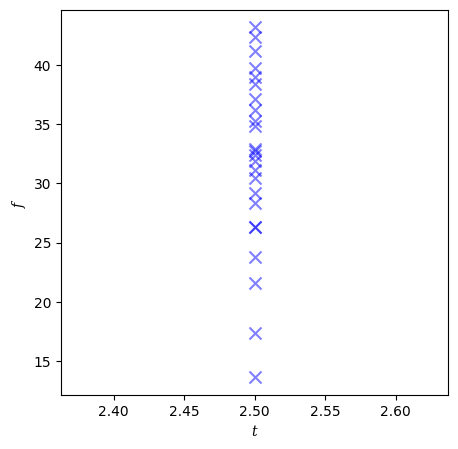

In [185]:
plt.figure(figsize=(5, 5))
plt.scatter(np.repeat(xvec[:, 0], thetavec.shape[0]), f, 
            marker='x', s=75, color='b', alpha=0.5)
plt.xlabel('$t$')
_ = plt.ylabel('$f$')

## `surmise`

In [186]:
#@title **Installation**
!pip install surmise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [187]:
#@title **Build emulator with `surmise` with `emulator` module**
from surmise.emulation import emulator

emu_balldrop = emulator(x=xvec, theta=thetavec, f=f,
                        args={'warnings': True})


/usr/local/lib/python3.10/dist-packages/surmise/emulation.py:168: UserWarning: Function supplementtheta not found in module!
  warnings.warn('Function supplementtheta not found in module!')


In [188]:
#@title Predict with emulator prediction object, `emu.predict()`

# predict at many parameters
kvec_test = np.linspace(0.001, 0.5, 30)
gvec_test = np.linspace(5, 25, 50)

K, G = np.meshgrid(kvec_test, gvec_test)
thetavec_test = np.array((K, G)).T.reshape(-1, 2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [189]:
#@markdown *Note:* `emu.predict()` returns a prediction object!
fpredobj = emu_balldrop.predict(x=xvec, theta=thetavec_test)  

# access the means and variances at the parameters
fpredmean = fpredobj.mean().reshape(30, 50)
fpredvar = fpredobj.var().reshape(30, 50)

In [190]:
# sanity check
np.isclose(emu_balldrop.predict(x=xvec, theta=np.array(((kvec_test[25], gvec_test[10])))).mean(),
           fpredmean[25, 10])

array([[ True]])

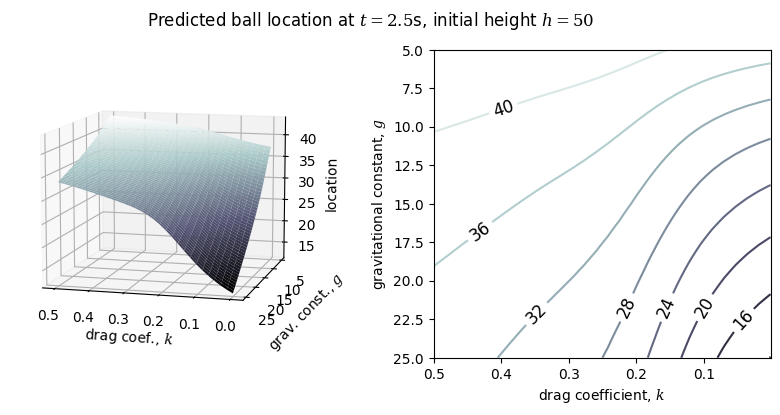

In [191]:
#@title <a name="prediction-plot"></a> How does the emulator predict across the parameter space?
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(K, G, fpredmean.T, cmap='bone')
ax1.view_init(10, 105)
ax1.set_xlabel('drag coef., $k$')
ax1.set_ylabel('grav. const., $g$')
ax1.set_zlabel('location')

ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contour(K, G, fpredmean.T, cmap='bone')
ax2.clabel(contour, contour.levels, colors='k', inline=True, fontsize=12)
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.set_xlabel('drag coefficient, $k$')
ax2.set_ylabel('gravitational constant, $g$')
plt.subplots_adjust(wspace=0.3)
_ = plt.suptitle('Predicted ball location at $t=2.5$s, initial height $h=50$')

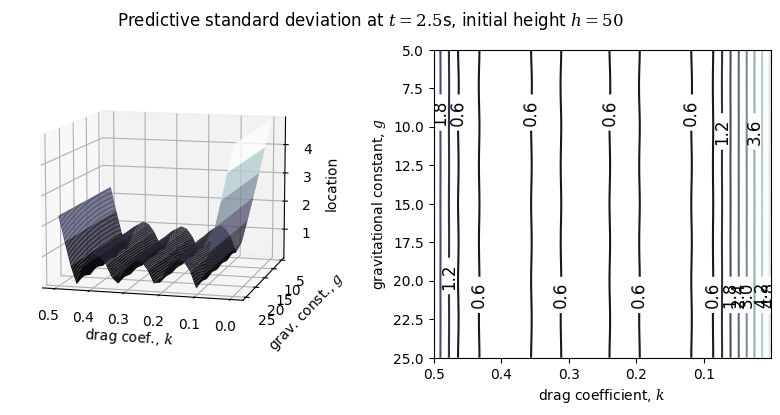

In [192]:
#@title What does the uncertainty look like?
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(K, G, np.sqrt(fpredvar).T, cmap='bone')
ax1.view_init(10, 105)
ax1.set_xlabel('drag coef., $k$')
ax1.set_ylabel('grav. const., $g$')
ax1.set_zlabel('location')

ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contour(K, G, np.sqrt(fpredvar).T, cmap='bone')
ax2.clabel(contour, contour.levels, colors='k', inline=True, fontsize=12)
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.set_xlabel('drag coefficient, $k$')
ax2.set_ylabel('gravitational constant, $g$')
plt.subplots_adjust(wspace=0.3)
_ = plt.suptitle('Predictive standard deviation at $t=2.5$s, initial height $h=50$')

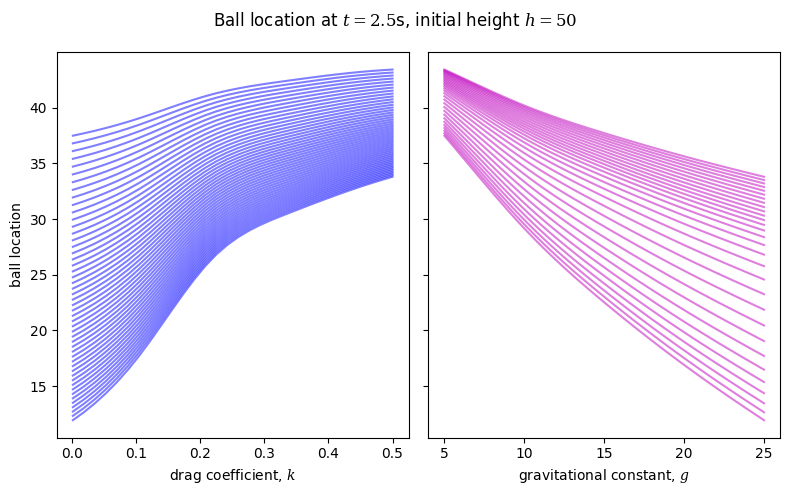

In [193]:
#@title Marginal plots (if you are interested)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
_ = ax[0].plot(kvec_test, fpredmean, 'b', alpha=0.5)
_ = ax[1].plot(gvec_test, fpredmean.T, 'm', alpha=0.5)

ax[0].set_xlabel('drag coefficient, $k$')
ax[0].set_ylabel('ball location')
ax[1].set_xlabel('gravitational constant, $g$')
plt.suptitle('Ball location at $t=2.5$s, initial height $h=50$')
plt.tight_layout()
plt.show()


---

**What have we achieved so far?**

We build an emulator for a single *time point*, and we are able to predict at any reasonable parameter.

---

**But can't we observe more than one time points?** 

**Can't we drop the ball at different heights?**

Yes and yes. 

---

## Emulator for multiple outputs

In [194]:
#@title **(Exercise)** Generate simulation data for multiple inputs

# set up multiple inputs
tvec = np.array((0.1, 0.5, 1.4, 2.7))
hvec = np.array((25, 50, 100))

T, H = np.meshgrid(tvec, hvec)
xvec_multi = np.array((T, H)).T.reshape(-1, 2)

# run the simulation at these inputs and the same parameters
fmat = ball_drop_xt(x=xvec_multi, theta=thetavec)

In [195]:
#@title **(Exercise)** What is the dimension of the output? What does each dimension correspond?

fmat.shape

(12, 24)

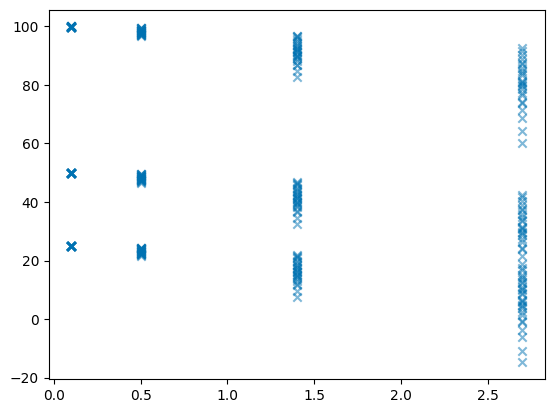

In [196]:
#@title **(Exercise)** Create a scatter plot of the simulation data against $t$.

plt.scatter(xvec_multi[:, 0].repeat(thetavec.shape[0]), fmat.reshape(-1),
            marker='x', alpha=0.5)

In [197]:
#@title **(Exercise)** Build an emulator using `surmise`.  
#@markdown *Note:* `surmise` can handle emulation with multiple outputs.  It uses a popular method called Principle Component Gaussian Process (PCGP).  We will look at how it works in a moment, but let's first build the emulator!

emu_multi = emulator(x=xvec_multi, theta=thetavec, f=fmat,
                     method='PCGP',
                     args={'warnings': True})

/usr/local/lib/python3.10/dist-packages/surmise/emulation.py:168: UserWarning: Function supplementtheta not found in module!
  warnings.warn('Function supplementtheta not found in module!')


In [198]:
#@title **(Exercise)** Predict the output at $(t=2.5, h=50)$.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [199]:
#@title **(Exercise)** Visualize the prediction and its uncertainty.

### Principle Component Gaussian Process (PCGP)

[fill in here]

## **Calibration**
Calibration refers to choosing a set of parameters so that the simulation model aligns well with what we observe in the physical system.

We believe that the physical system is modeled by the simulation model
$$ y(x) = f(x, \theta) + \epsilon, \quad  \epsilon \sim \mathsf{N}(0, \sigma^2_\epsilon), $$
but we need to determine what parameter values aligns the simulation model and the data.

### **Gentle reminder of Bayesian statistics**
After we observe some physical data $y$, (in this case, go outside, grab a ball and drop it at $h=50$ and observe its location after $t=2.5$s.)

We will try to guess, given the physical data, what parameter values are more likely, using

$$\underbrace{p(\theta~|~y)}_{\rm posterior} \propto \underbrace{p(y~|~\theta)}_{\rm likelihood}~\underbrace{p(\theta)}_{\rm prior}.$$

**Example**: Say you actually dropped a ball at $h=50$ and observed its location after $t=2.5$s, you recorded that $y = 20$. What can you say about the parameters? [*Recall* the prediction plot from earlier.](#prediction-plot)

**(Optional) Details on the likelihood**

[fill in here]

### **Physical data**

Now suppose you are handed some physical data from an extra-terrestrial being, asking for help to understand their planet...


In [200]:
#@title Surprisingly they also use the same time and distance units... you think your current simulation model could work.

In [201]:
#@title This is the data they handed us.
# The inputs are given to us as:
tvec_et = np.array((1, 1.414, 1.732, 2.236, 2.645, 3))
hvec_et = np.array((7, 14, 21, 28, 35))

Tet, Het = np.meshgrid(tvec_et, hvec_et)
xvec_et = np.array((Tet, Het)).T.reshape(-1, 2)

# The outputs are given to us as:
y = np.array([[  2.6795721 ],
       [ 11.29917315],
       [ 16.75635225],
       [ 25.50902197],
       [ 31.68670446],
       [  1.36272669],
       [  5.00726961],
       [ 14.20124892],
       [ 21.70062911],
       [ 28.97993106],
       [ -1.3928248 ],
       [  7.91004077],
       [ 11.83250397],
       [ 21.14746178],
       [ 28.38791665],
       [ -3.55554223],
       [  4.37518697],
       [  8.11264007],
       [ 17.25218299],
       [ 23.34185996],
       [ -9.05673834],
       [ -1.77144211],
       [  6.47887829],
       [ 12.8869224 ],
       [ 21.13895916],
       [-10.48741053],
       [ -4.03449921],
       [  1.12235881],
       [ 10.48067863],
       [ 15.41933186]]).squeeze()
yvar = np.ones_like(y)

### Here is our task: 

Each of us will attempt to build an emulator. We will come back to calibrate our models together and see what our guesses look like.

In [203]:
#@title **(Exercise)** Build an emulator for these inputs. Feel free to pick your own set of parameters. Remember, you have to generate a new set of `fmat`.
fmat_et = ball_drop_xt(xvec_et, thetavec)

emu_et = emulator(x=xvec_et, theta=thetavec, f=fmat_et,
                  method='PCGP', 
                  args={'warnings': True})

/usr/local/lib/python3.10/dist-packages/surmise/emulation.py:168: UserWarning: Function supplementtheta not found in module!
  warnings.warn('Function supplementtheta not found in module!')


In [204]:
#@title **(Exercise)** Check the prediction and its uncertainty.  You can decide to change your set of parameters and rebuild your emulator.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **What does the prior look like?**

The prior is your choice, given any knowledge you have about the parameters.

For example, suppose the drag coefficient and the gravitational constant are both more likely to be in the middle of the parameter space, and less likely to be close to the boundary.

In [205]:
#@title **Prior definition**

# useful to have scipy's statistics module
import scipy.stats as sps

# set up a prior class for the parameter
class prior_balldrop:
  # define the log density for the prior
  def lpdf(theta): 
    # theta = (k, g), k in [kL, kU], g in [gL, gU]
    return (sps.beta.logpdf((theta[:, 0] - kL)/(kU - kL), 1.5, 1.5) + 
            sps.beta.logpdf((theta[:, 1] - gL)/(gU - gL), 1.5, 1.5)).reshape((theta.shape[0], 1))  # the .reshape((n, 1)) is currently required
  # define a random number generator according to the density
  def rnd(n):
    return np.vstack((sps.beta.rvs(1.5, 1.5, size=n)*(kU - kL) + kL,
                     sps.beta.rvs(1.5, 1.5, size=n)*(gU - gL) + gL)).T

Text(0.5, 0, 'gravitational constant, $g$')

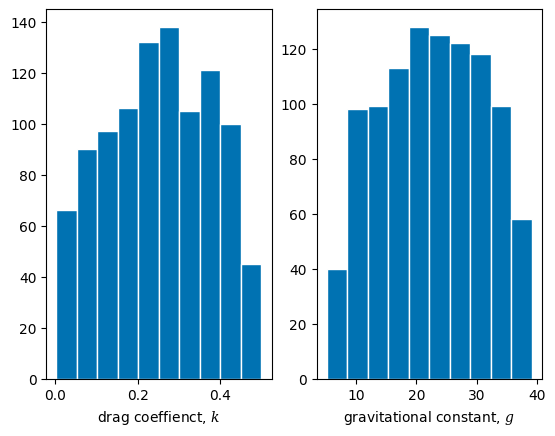

In [206]:
#@title Visualize prior samples
prior_samples = prior_balldrop.rnd(1000)

fig, ax = plt.subplots(1, 2)
ax[0].hist(prior_samples[:, 0], edgecolor='w')
ax[1].hist(prior_samples[:, 1], edgecolor='w')
ax[0].set_xlabel('drag coeffienct, $k$')
ax[1].set_xlabel('gravitational constant, $g$')

In [207]:
#@title **Calibrate parameters with `calibrator` module**
from surmise.calibration import calibrator

In [213]:
#@title Building a calibrator
cal_et = calibrator(emu=emu_et,
                 y=y, 
                 x=xvec_et,
                 thetaprior=prior_balldrop,
                 method='directbayeswoodbury',
                #  args={'sampler': 'LMC'},
                 yvar=yvar,
                 )

In [209]:
# plotting aid functions
def plot_theta(cal, whichtheta):
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    cal_theta = cal.theta.rnd(1000) 
    axs[0].plot(cal_theta[:, whichtheta])
    axs[1].boxplot(cal_theta[:, whichtheta])
    axs[2].hist(cal_theta[:, whichtheta])
    plt.show()

def plot_preds(x, cal, axs):
    post = cal.predict(x)
    samples = post.rnd(s = 1000)
    for k in np.unique(x[:, 1]):
        inds = np.where(x[:, 1] == k)[0]
        upper = np.percentile(samples[:, inds], 97.5, axis = 0)
        lower = np.percentile(samples[:, inds], 2.5, axis = 0)
        axs.fill_between(x[inds, 0], lower, upper, color = 'grey', alpha=0.25)
        axs.plot(x[inds, 0], y[inds], 'bx', markersize = 5)
    return(axs)

In [214]:
#@title From the calibrator object, we can draw from the posterior.
posttheta = cal_et.theta.rnd(1000)

# posterior mean of parameters
posttheta.mean(0)

array([0.11892826, 7.63981198])

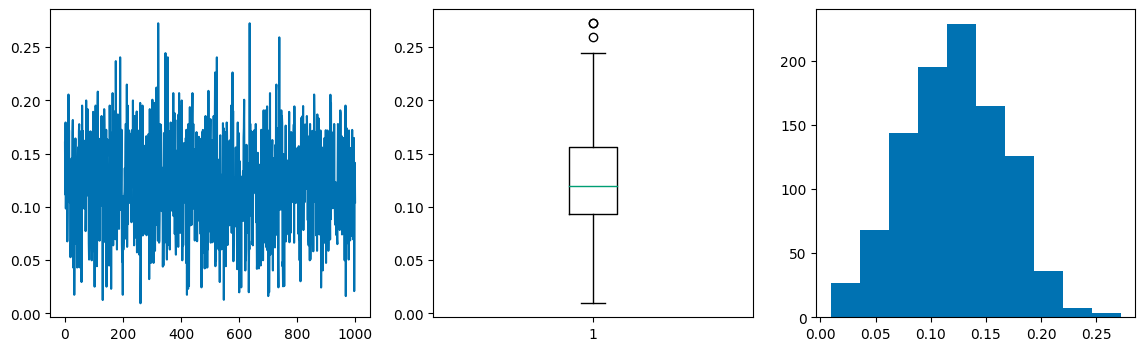

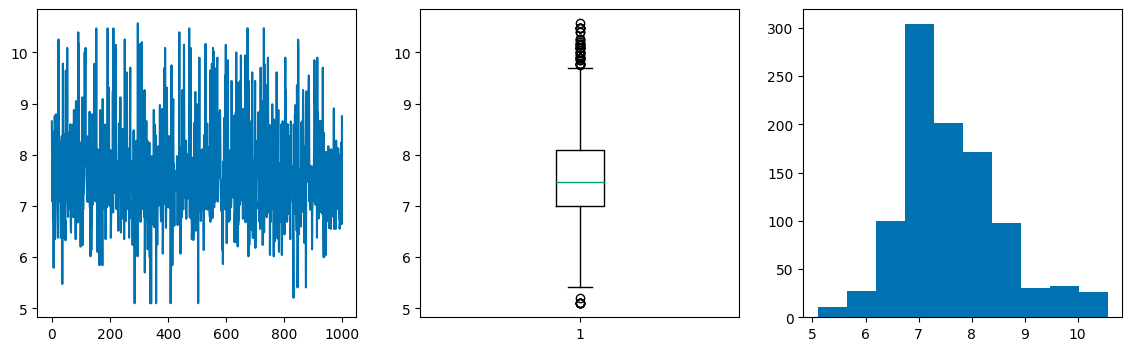

In [215]:
#@title Visualize the posterior samples
plot_theta(cal_et, 0)
plot_theta(cal_et, 1)

Text(0, 0.5, 'ball location')

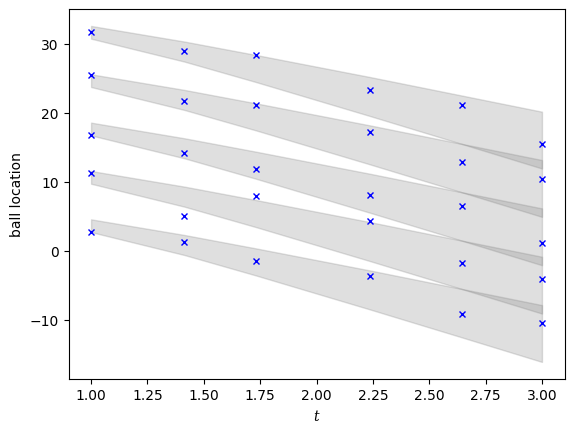

In [216]:
#@title From the calibrator object, we can also predict using the calibrated parameters
#@markdown Like `emu.predict()`, `cal.predict()` produces a prediction object
post_pred_et = cal_et.predict(x=xvec_et)

# posterior prediction samples
post_samples = post_pred_et.rnd(1000)

fig, ax = plt.subplots(1, 1)
plot_preds(x=xvec_et, cal=cal_et, axs=ax)
ax.set_xlabel('$t$')
ax.set_ylabel('ball location')

## **Caveat: simulation code failures**

